# Self-Learning

## Clasificación SemiSupervisada

La clasificación consiste en la asignación de una categoría a un objeto/individuo (o a varios).

En cualquier problema de clasificación hay que identificar...
* ¿Qué cosas/objetos/individuos queremos clasificar?
* ¿Qué datos (o variables medidas) tenemos de estos?
* ¿Cuáles (o cuántas) serían las (posibles) categorías o clases?

En **clasificación supervisada** se requiere tener a disposición un conjunto de muestras u objetos ya clasificados (tiene que ser numeroso y representativo).
Con este conjunto se aprende a clasificar nuevas muestras y es llamado conjunto de entrenamiento.
Cuando además ya tenemos de antemano muestras no clasificadas y las consideramos en la clasificación lo llamamos **clasificación semisupervisada**.

En esta notebook veremos **Clasificación SemiSupervisada dentro de una imagen**.

## Clasificación de Imágenes

Primero hay que identificar que tipo de clasificación se quiere realizar:

* **Dentro de una imagen (clasificación de pixeles, segmentación, detección de zonas)**
* **Asignar una imagen completa a una categoría (etiquetado, taggeo)**

Abordaremos...

### Clasificación dentro de una imagen (Segmentación)

Dividir a la imagen en regiones.
Los objetos/muestras a clasificar son los pixeles. ¿Qué datos/variables/características/features tenemos (o podemos obtener) de cada pixel?

Cada pixel tiene un vector de datos o características.
Por lo que puede tener una, tres, o más (características/datos).

**Ejemplo:** Imágenes a color *RGB*.

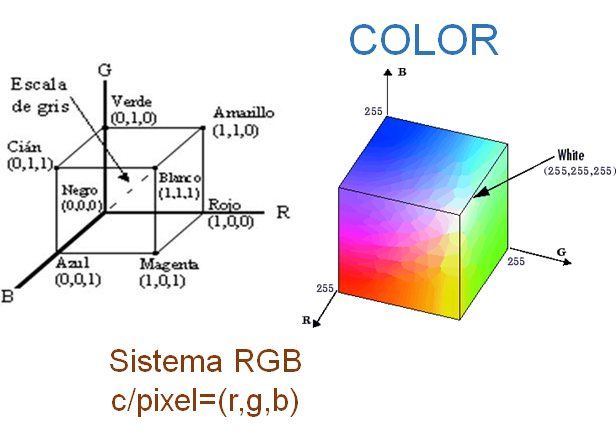

En *Python* primero hay que instalar, por única vez, alguna librería para leer imágenes (*OpenCV*, *PIL*, o *SimpleITK*).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

In [2]:
import cv2

import matplotlib.patches as mpatches

from mpl_toolkits.mplot3d import Axes3D

In [3]:
campo_cv = cv2.imread('Images/Field.png')
print(f'Dimensiones: {campo_cv.shape}')

campo = campo_cv.copy()
campo[:, :, [2, 1, 0]] = campo_cv # OpenCV lee en orden BGR
print(f'Tenemos {campo.shape[0]} x {campo.shape[1]} pixeles RGB ({campo.shape[2]} canales)')
print(f'Tipo de Datos: {campo.dtype}')

Dimensiones: (359, 479, 3)
Tenemos 359 x 479 pixeles RGB (3 canales)
Tipo de Datos: uint8


Componente R del pixel (0,0): 186
Componente G del pixel (0,0): 155
Componente B del pixel (0,0): 161


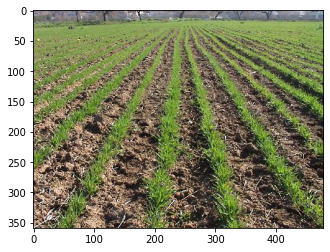

In [4]:
print(f'Componente R del pixel (0,0): {campo[0, 0, 0]}')
print(f'Componente G del pixel (0,0): {campo[0, 0, 1]}')
print(f'Componente B del pixel (0,0): {campo[0, 0, 2]}')

plt.imshow(campo)
plt.show()

# Clasificación Supervisada / SemiSupervisada

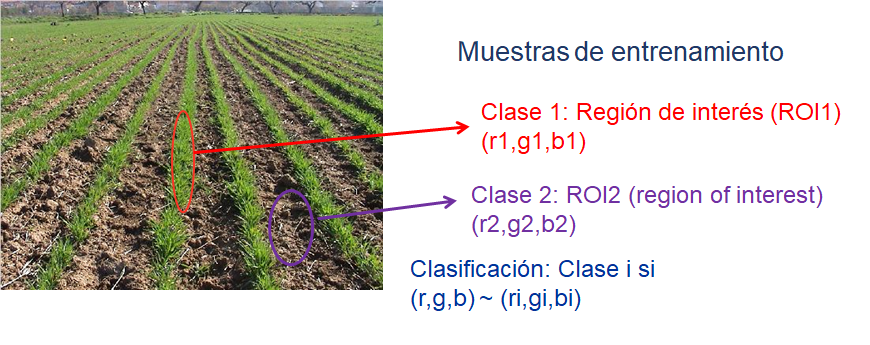

### K-Nearest Neighbours

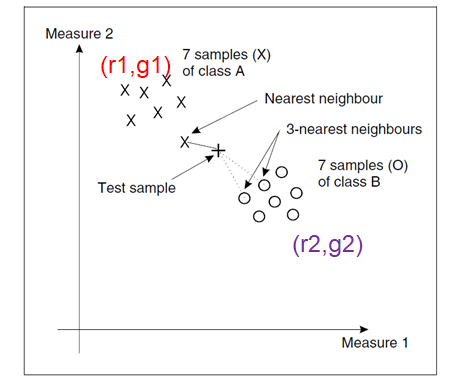

**Pasemos los pixeles a un Dataframe**

Un pixel por fila, donde desarmamos la espacialidad.

In [5]:
dims = campo.shape
# Filas y Columnas
cant_filas = dims[0]
cant_columnas = dims[1]
# Cantidad de Pixeles
cant_pixeles = cant_filas * cant_columnas

data = np.zeros([cant_pixeles, 4], dtype='int')
for f in range(cant_filas):
    for c in range(cant_columnas):
        nro = f * cant_columnas + c
        data[nro, 0] = nro
        data[nro, 1:4] = campo[f, c, :]

df = pd.DataFrame(data, columns=['PixelID', 'Rojo', 'Verde', 'Azul'])

print(f'Tamaño de DF: {df.shape}')
df.head()        

Tamaño de DF: (171961, 4)


,PixelID,Rojo,Verde,Azul
0,0,186,155,161
1,1,202,171,176
2,2,190,159,165
3,3,203,172,177
4,4,189,160,164


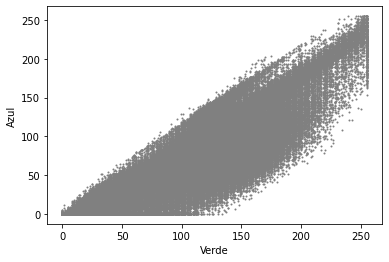

In [6]:
variables = ['Rojo', 'Verde', 'Azul']

variable1 = variables[1]
variable2 = variables[2]

f1 = df[variable1].values
f2 = df[variable2].values

plt.scatter(f1, f2, c='gray', s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.show()

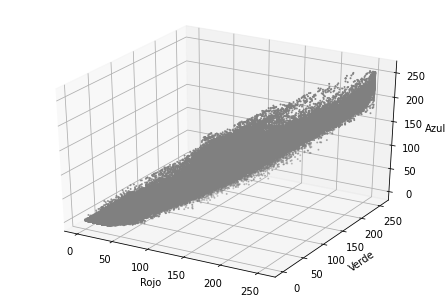

¡Un caramelo para el que encuentre clusters ahí!


In [7]:
fig = plt.figure()

ax = Axes3D(fig)

ax.scatter(df[variables[0]].values,
           df[variables[1]].values,
           df[variables[2]].values,
           c='gray',
           s=1
           )

ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
plt.show()

print('¡Un caramelo para el que encuentre clusters ahí!')

**Clustering: KMedias**

No Supervisado

In [8]:
from sklearn.cluster import KMeans

# Número de Clusters (Cosecha, Tierra, Fondo)
n_clust = 3
df_km = pd.DataFrame(data[:, 1:4], columns=variables)

km = KMeans(n_clusters=n_clust)
km.fit(df_km) # Utiliza 3 dimensiones (canales)

# Recuperación de las etiquetas
clusters = km.labels_
print(f'Suma de los cuadrados de las distancias al Cluster (Inertia): {km.inertia_}')

Suma de los cuadrados de las distancias al Cluster (Inertia): 308743430.13011485


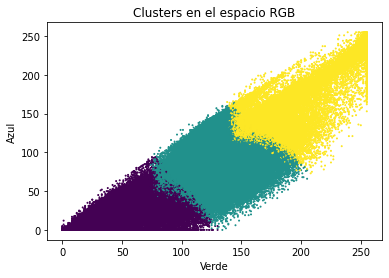

In [9]:
variable1 = variables[1]
variable2 = variables[2]

f1 = df[variable1].values
f2 = df[variable2].values

plt.scatter(f1, f2, c=clusters, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.title('Clusters en el espacio RGB')
plt.show()

Cantidad de Etiquetas: 3


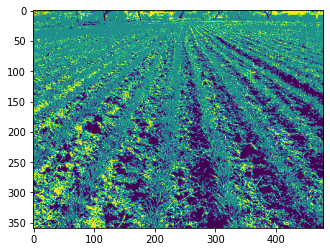

In [10]:
print(f'Cantidad de Etiquetas: {max(km.labels_) + 1}')

img_clusters = km.labels_.reshape(cant_filas, cant_columnas)

plt.imshow(img_clusters)
plt.show()

### SemiSupervisado: Etiquetado de algunos pixeles.
**Selección de cada ROI (Region Of Interest / Región de Interés)**

*IMPORTANTE*

Los tres bloques siguientes sirven para elegir las regiones de entrenamiento y pueden reemplazarse por el que les sigue.

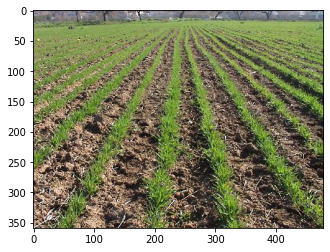

In [11]:
plt.imshow(campo)
plt.show()

In [12]:
roi1 = (136, 241, 47, 106) # Tierra
roi2 = (192, 269, 33, 56) # Cosecha
roi3 = (145, 1, 121, 14) # Fondo

rois = [roi1, roi2, roi3]

print('En cada ROI se guardan: (Columna, Fila, AnchoColumna, AltoFila)')

En cada ROI se guardan: (Columna, Fila, AnchoColumna, AltoFila)


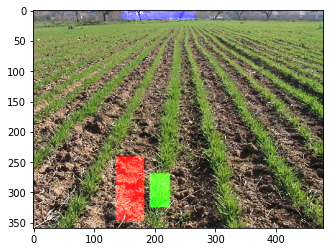

Rojo: Tierra | Verde: Cosecha | Azul: Fondo


In [13]:
campo_rois = campo.copy()

for i in range(3):
  roi = rois[i]
  columna = roi[0]
  columnas = roi[0] + roi[2]
  fila = roi[1]
  filas = roi[1] + roi[3]
  campo_rois[fila : filas, columna : columnas, i] = 255

plt.imshow(campo_rois)
plt.show()
print('Rojo: Tierra | Verde: Cosecha | Azul: Fondo')

In [14]:
cantidad = 0
for i in range(3):
    cantidad = cantidad + (rois[i][2] * rois[i][3])
print(f'Pixeles Etiquetados: {cantidad}')

data_label = np.zeros([cantidad, 5], dtype='int')
target = np.zeros(cantidad, dtype='int')
cuenta = 0
for i in range(3):
    # Elegimos una ROI
    roi = rois[i]
    for fil in range(roi[1], roi[1] + roi[3]):
        for col in range(roi[0], roi[0] + roi[2]):
            # Llevamos la cuenta de las etiquetas
            nro = fil * cant_columnas + col
            data_label[cuenta, 0] = nro
            data_label[cuenta, 1:4] = campo[fil, col, :]
            data_label[cuenta, 4] = i + 1
            target[cuenta] = i + 1
            cuenta = cuenta + 1

df_etiquetado = pd.DataFrame(data_label, columns=['PixelID', 'Rojo', 'Verde', 'Azul', 'Etiqueta'])
print(f'Dimensiones del DF: {df_etiquetado.shape}')

df_etiquetado.head()

Pixeles Etiquetados: 8524
Dimensiones del DF: (8524, 5)


,PixelID,Rojo,Verde,Azul,Etiqueta
0,115575,101,104,77,1
1,115576,111,110,90,1
2,115577,104,97,89,1
3,115578,34,26,23,1
4,115579,29,22,16,1


**Graficamos los pixeles etiquetados (`roi1`, `roi2`, `roi3`)**

Entrenamiento

Cantidad de muestras etiquetadas: 8524
Cantidad de clases etiquetadas: 3
Cantidad de dimensiones: 3
Se grafican de a 2 variables


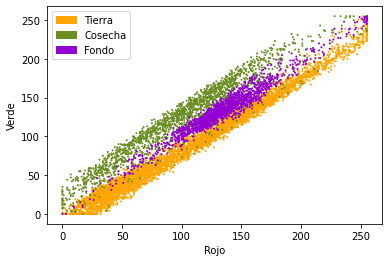

In [15]:
colores = ['orange', 'olivedrab', 'darkviolet']

variable1 = variables[0]
variable2 = variables[1]

f1 = df_etiquetado[variable1].values
f2 = df_etiquetado[variable2].values

# Vamos a pintar en colores las clases:
# Rojo - 0 | Verde - 1 | Azul - 2
asignar = []
l = len(target)
print(f'Cantidad de muestras etiquetadas: {l}')
print(f'Cantidad de clases etiquetadas: {3}')
print(f'Cantidad de dimensiones: {3}')
print(f'Se grafican de a {2} variables')

for k in range(l):
    if target[k] == 1:
        asignar.append(colores[0])
    elif target[k] == 2:
        asignar.append(colores[1])
    else:
        asignar.append(colores[2])

plt.scatter(f1, f2, c=asignar, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
patch1 = mpatches.Patch(color=colores[0], label='Tierra')
patch2 = mpatches.Patch(color=colores[1], label='Cosecha')
patch3 = mpatches.Patch(color=colores[2], label='Fondo')
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

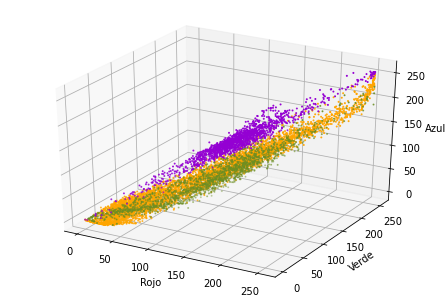

In [16]:
fig = plt.figure()

ax = Axes3D(fig)

ax.scatter(df_etiquetado[variables[0]].values,
           df_etiquetado[variables[1]].values,
           df_etiquetado[variables[2]].values,
           c=asignar,
           s=1
           )

ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
plt.show()

In [17]:
# Base Completa, con etiquetados (1, 2, 3) y no etiquetados (0)
df_completo = df.copy()
df_completo.astype(int) 
df_completo['Etiqueta'] = 0 * df_completo['PixelID']

# Se asignan en el DF las etiquetas de ROIS
for i in range(l):
    lugar = df_etiquetado['PixelID'][i].astype(int)
    df_completo['Etiqueta'][lugar] = df_etiquetado['Etiqueta'][i]

df_completo.sample(5, random_state=123)

,PixelID,Rojo,Verde,Azul,Etiqueta
165034,165034,100,93,77,0
146531,146531,109,135,44,0
77878,77878,171,203,102,0
89071,89071,167,155,141,0
46181,46181,125,155,57,0


Cantidad de NO Etiquetados: 163437
Cantidad de Pixeles: 171961
Proporción de Etiquetados: 0.049569379103401354


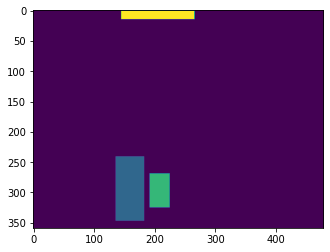

In [18]:
print(f'Cantidad de NO Etiquetados: {sum(df_completo.Etiqueta == 0)}')
print(f'Cantidad de Pixeles: {cant_pixeles}')
print(f'Proporción de Etiquetados: {sum(df_completo.Etiqueta != 0) / cant_pixeles}')

clasificacion_ROIs = df_completo.Etiqueta.values.reshape(dims[0], dims[1])
plt.imshow(clasificacion_ROIs)
plt.show()

**Entrenamos un modelo K-Nearest Neighbors con los pixeles que etiquetamos (`roi1`, `roi2`, `roi3`)** 

Con *scikit learn* elegimos el valor de `k = 5` (5 vecinos).

In [19]:
n_neighbors = 5
data_rgb = data_label[:, 1:4]

knn = KNeighborsClassifier(n_neighbors)
knn.fit(data_rgb, target)

print(f'Accuracy del clasificador K-NN en el conjunto de entrenamiento: {knn.score(data_rgb, target)}')

Accuracy del clasificador K-NN en el conjunto de entrenamiento: 0.9723134678554669


### Clasificación

Clasifiquemos la imagen completa.
Se clasifican todos los pixeles usando el modelo entrenado.

Predicción de un pixel aleatorio [2]


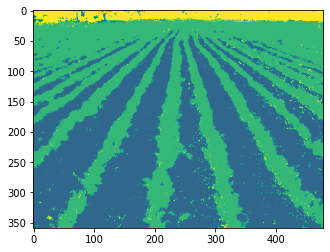

In [20]:
clasif = np.zeros(dims[0:2], dtype='int')

print(f'Predicción de un pixel aleatorio {knn.predict([[40, 80, 40]])}')

for i in range(dims[0]): # Filas
    for j in range(dims[1]): # Columnas
        clasif[i, j] = knn.predict([campo[i, j, :]])

clasif[0, 0] = 0 # Para unificar paletas (con 4 colores)

plt.imshow(clasif)
plt.show()

#### Mejora de la clasificación: **co-learning**

Usando conocimiento de dominio.
En imágenes, por ejemplo, la información espacial.

* Filtro o algoritmo de modas (puede ser iterado).
* Moda, es el valor más repetido.

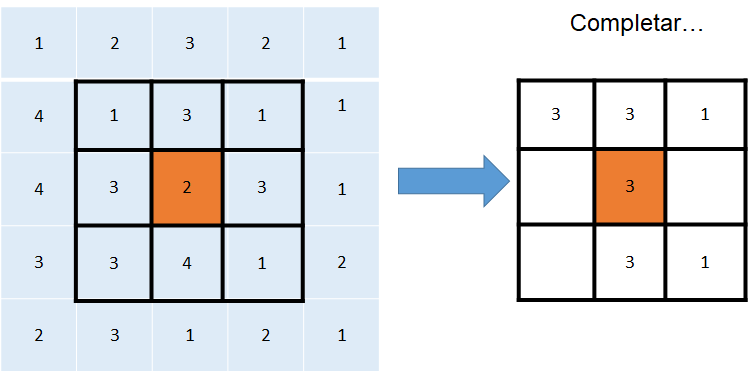

In [21]:
from statistics import mode

clasif_K = clasif.copy()

# Necesitamos un margen para el Kernel...
for i in range(2, dims[0] - 2): # Filas
    for j in range(2, dims[1] - 2): # Columnas
        try:
            # Tomamos la moda en el vecindario inmediato
            clasif_K[i, j] = mode(clasif[i - 2 : i + 3, j - 2 : j + 3].ravel())
        except:
            clasif_K[i, j] = clasif[i, j]

clasif_K[0, 0] = 0 # Para unificar paletas (con 4 colores)

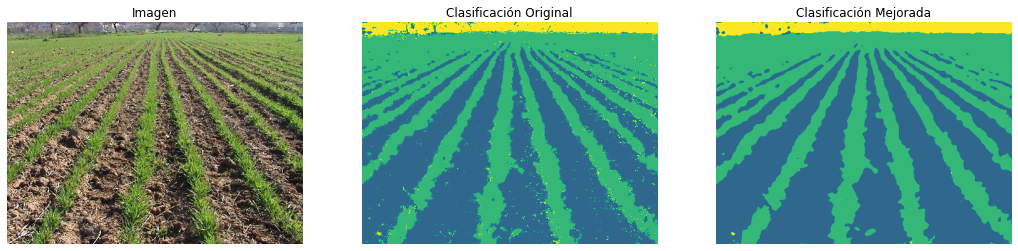

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(18)

axs[0].imshow(campo)
axs[0].set_title('Imagen')
axs[0].axis('off')

axs[1].imshow(clasif)
axs[1].set_title('Clasificación Original')
axs[1].axis('off')

axs[2].imshow(clasif_K)
axs[2].set_title('Clasificación Mejorada')
axs[2].axis('off')

plt.show()

### Asignación progresiva

In [23]:
n_neighbors = 6

knn6 = KNeighborsClassifier(n_neighbors)
knn6.fit(data_rgb, target)
print(f'Accuracy del clasificador K-NN (k = 6) en el conjunto de entrenamiento: {knn6.score(data_rgb, target)}')

Accuracy del clasificador K-NN (k = 6) en el conjunto de entrenamiento: 0.9693805725011732


**Utilizamos algún criterio para incrementar la muestra de entrenamiento de manera progresiva**

Elegimos comparar 5 vecinos con 6 vecinos, si coincide lo suma a la muestra de entrenamiento.

Faltantes: 2645
Proporción sin etiquetas: [0.015381394618547229]


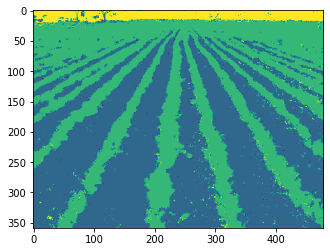

In [24]:
# Loop 1
prop = []
r1s = knn.predict(data[:, 1:4])
r2s = knn6.predict(data[:, 1:4])
for i in range(cant_pixeles):
    if df_completo.Etiqueta[i] == 0:
        r1 = r1s[i]
        r2 = r2s[i]
        if r1 == r2:
            df_completo.Etiqueta[i] = r1 # Le asigno alguno cuando coinciden.

print(f'Faltantes: {sum(df_completo.Etiqueta == 0)}')

prop.append(sum(df_completo.Etiqueta == 0) / cant_pixeles)
print(f'Proporción sin etiquetas: {prop}')

clasif_iter = df_completo.Etiqueta.values.reshape(dims[0], dims[1])

plt.imshow(clasif_iter)
plt.show()

**Se entrena de nuevo los clasificadores con las muestras de entrenamiento actualizadas...**

...y se usa el mismo criterio para etiquetar nuevos datos.

Comparar *knn 5* vecinos con *knn 6* vecinos.
Si coincide lo agrega a la muestra de entrenamiento y así siguiendo...

Faltantes: 197
Proporción sin etiquetas: [0.015381394618547229, 0.0011456085972982246]


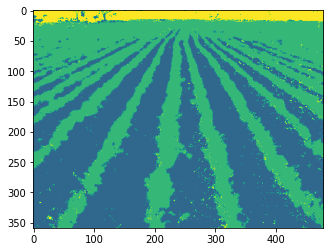

In [25]:
# Loop 2
data_rgb = df_completo[df_completo.Etiqueta != 0].values[:, 1:4]
target = df_completo.Etiqueta[df_completo.Etiqueta != 0]
knn.fit(data_rgb, target)
knn6.fit(data_rgb, target)

r1s = knn.predict(data[:, 1:4])
r2s = knn6.predict(data[:, 1:4])
for i in range(cant_pixeles):
    if df_completo.Etiqueta[i] == 0:
        r1 = r1s[i]
        r2 = r2s[i]
        if r1 == r2:
            df_completo.Etiqueta[i] = r1

print(f'Faltantes: {sum(df_completo.Etiqueta == 0)}')

prop.append(sum(df_completo.Etiqueta == 0) / cant_pixeles)
print(f'Proporción sin etiquetas: {prop}')

clasif_iter = df_completo.Etiqueta.values.reshape(dims[0], dims[1])

plt.imshow(clasif_iter)
plt.show()

Faltantes: 67
Proporción sin etiquetas: [0.015381394618547229, 0.0011456085972982246, 0.00038962322852274643]


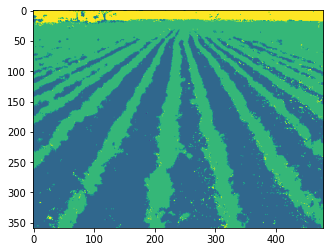

In [26]:
# Loop 3
data_rgb = df_completo[df_completo.Etiqueta != 0].values[:, 1:4]
target = df_completo.Etiqueta[df_completo.Etiqueta != 0]
knn.fit(data_rgb, target)
knn6.fit(data_rgb, target)

r1s = knn.predict(data[:, 1:4])
r2s = knn6.predict(data[:, 1:4])
for i in range(cant_pixeles):
    if df_completo.Etiqueta[i] == 0:
        r1 = r1s[i]
        r2 = r2s[i]
        if r1 == r2:
            df_completo.Etiqueta[i] = r1

print(f'Faltantes: {sum(df_completo.Etiqueta == 0)}')

prop.append(sum(df_completo.Etiqueta == 0) / cant_pixeles)
print(f'Proporción sin etiquetas: {prop}')

clasif_iter = df_completo.Etiqueta.values.reshape(dims[0], dims[1])

plt.imshow(clasif_iter)
plt.show()

Faltantes: 54
Proporción sin etiquetas: [0.015381394618547229, 0.0011456085972982246, 0.00038962322852274643, 0.0003140246916451986]


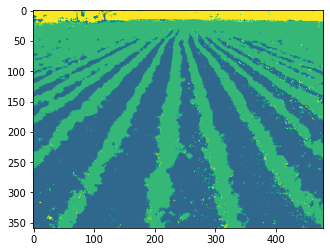

In [27]:
# Loop 4
data_rgb = df_completo[df_completo.Etiqueta != 0].values[:, 1:4]
target = df_completo.Etiqueta[df_completo.Etiqueta != 0]
knn.fit(data_rgb, target)
knn6.fit(data_rgb, target)

r1s = knn.predict(data[:, 1:4])
r2s = knn6.predict(data[:, 1:4])
for i in range(cant_pixeles):
    if df_completo.Etiqueta[i] == 0:
        r1 = r1s[i]
        r2 = r2s[i]
        if r1 == r2:
            df_completo.Etiqueta[i] = r1

print(f'Faltantes: {sum(df_completo.Etiqueta == 0)}')

prop.append(sum(df_completo.Etiqueta == 0) / cant_pixeles)
print(f'Proporción sin etiquetas: {prop}')

clasif_iter = df_completo.Etiqueta.values.reshape(dims[0], dims[1])

plt.imshow(clasif_iter)
plt.show()

Faltantes: 49
Proporción sin etiquetas: [0.015381394618547229, 0.0011456085972982246, 0.00038962322852274643, 0.0003140246916451986, 0.0002849483313076802]


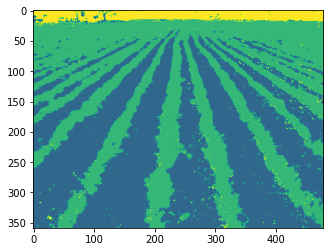

In [28]:
# Loop 5
data_rgb = df_completo[df_completo.Etiqueta != 0].values[:, 1:4]
target = df_completo.Etiqueta[df_completo.Etiqueta != 0]
knn.fit(data_rgb, target)
knn6.fit(data_rgb, target)

r1s = knn.predict(data[:, 1:4])
r2s = knn6.predict(data[:, 1:4])
for i in range(cant_pixeles):
    if df_completo.Etiqueta[i] == 0:
        r1 = r1s[i]
        r2 = r2s[i]
        if r1 == r2:
            df_completo.Etiqueta[i] = r1

print(f'Faltantes: {sum(df_completo.Etiqueta == 0)}')

prop.append(sum(df_completo.Etiqueta == 0) / cant_pixeles)
print(f'Proporción sin etiquetas: {prop}')

clasif_iter = df_completo.Etiqueta.values.reshape(dims[0], dims[1])

plt.imshow(clasif_iter)
plt.show()

**Si no se tuvieron buenos resultados puede ser por muchos motivos...**

* El algoritmo puede fallar y no converger a los aglomerados.
* Las características consideradas no son suficientes, o no son las adecuadas, por ejemplo.